### Objective:

The **main purpose** is to build a **Recommendation System** able to filter and compute similarity between items. 

In this case, a dataset of Steam Games was provided and the main goal then is to create the system from a content-based filtering approach using the Cosine Similarity Algorithm (which is a simple solution for the dot product formula from Liear Algebra).

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

## **Pre-modeling Stage**

### Exploring data

In [2]:
df = pd.read_json('./data/games.json.gz', lines=True, compression='gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32133 entries, 0 to 32132
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   item_id       32133 non-null  int64 
 1   developer     32133 non-null  object
 2   app_name      32133 non-null  object
 3   genres        32133 non-null  object
 4   tags          32133 non-null  object
 5   specs         32133 non-null  object
 6   release_year  32133 non-null  int64 
 7   price         32133 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.0+ MB


Notice columns are objects except for the id.

In [3]:
# Copying to avoid any change on the original df
df_games = df.copy()
df_games.head()

,item_id,developer,app_name,genres,tags,specs,release_year,price
0,761140,Kotoshiro,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]",[Single-player],2018,4.99
1,643980,Secret Level SRL,Ironbound,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",2018,Free To Play
2,670290,Poolians.com,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",2017,Free to Play
3,767400,彼岸领域,弹炸人2222,"[Action, Adventure, Casual]","[Action, Adventure, Casual]",[Single-player],2017,0.99
4,773570,Unknown,Log Challenge,Empty,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2016,2.99


- How many games were released per year?
- What is the maximum number of games? and the minimum?
- How does it look?

In [4]:
# Value count for each year
years = df_games['release_year'].value_counts()

print(f'Year when the most games were released: {years.idxmax()} - {years[years.idxmax()]} games')
print(f'Year when the least games were released: {years.idxmin()} - {years[years.idxmin()]} game')


Year when the most games were released: 2017 - 9560 games
Year when the least games were released: 1986 - 1 game


(0.0, 1000.0)

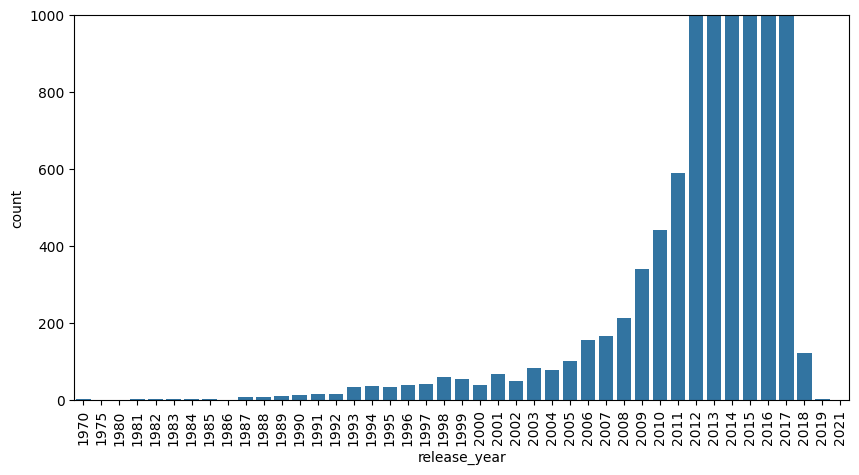

In [5]:
#Plotting
ax = sns.countplot(df_games, x='release_year')
ax.figure.set_size_inches(10,5)
ax.tick_params(axis='x', rotation=90) # Rotate x ticks
ax.set_ylim(top=1000) # Limitting y axis to 4000

Number of games released in a year increases drastically since early 2000's.

What about genres and tags?

In [6]:
df_games[['genres', 'tags']]

,genres,tags
0,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]"
1,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game..."
2,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind..."
3,"[Action, Adventure, Casual]","[Action, Adventure, Casual]"
4,Empty,"[Action, Indie, Casual, Sports]"
...,...,...
32128,"[Casual, Indie, Simulation, Strategy]","[Strategy, Indie, Casual, Simulation]"
32129,"[Casual, Indie, Strategy]","[Strategy, Indie, Casual]"
32130,"[Indie, Racing, Simulation]","[Indie, Simulation, Racing]"
32131,"[Casual, Indie]","[Indie, Casual, Puzzle, Singleplayer, Atmosphe..."


Taking a quick look it's easy to see that 'genres' and 'tags' for a game are quite similar and in some cases (look at the bottom entries) **tags can be more informative than genres**. That is, the **list of 'tags' is longer than the list of 'genres'**, which provides more information about the game.

There must be 'Empty' values for both. What can be done with those empty values?

In [7]:
print('Games with empty lists of genres:',
       len(df_games[df_games['genres'] == 'Empty'][['genres','tags']])
    )

print('Games with empty lists of tags:',
       len(df_games[df_games['tags'] == 'Empty'][['genres','tags']])
    )

print('Games where both lists are ampty:',
      len(df_games.loc[(df_games['genres'] == 'Empty') & (df_games['tags'] == 'Empty')])
    )

Games with empty lists of genres: 3282
Games with empty lists of tags: 162
Games where both lists are ampty: 138


Let's take a look on the legnth of genres and tags lists.

Maximum lenght of tags list: 20
Average lenght of tags: 5.266
Median: 4.0
Std: 5


<Axes: xlabel='tags_number', ylabel='count'>

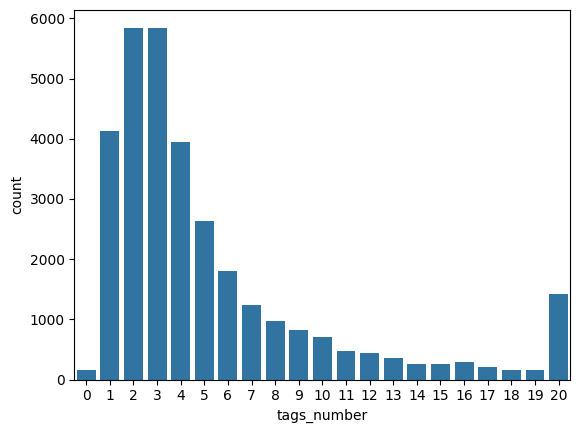

In [8]:
# Creating a new feature corresponding to 
# The counting of tags for each item
df_games['tags_number'] = df_games['tags'].map(lambda l: len(l) if l != 'Empty' else 0)

print('Maximum lenght of tags list:', df_games['tags_number'].max())
print('Average lenght of tags:', round(df_games['tags_number'].mean(), 3))
print('Median:', df_games['tags_number'].median())
print('Std:', round(df_games['tags_number'].std()))

# Plotting distribution
sns.countplot(df_games, x='tags_number')

Maximum lenght of genres list: 11
Average lenght of genres list: 2.227
Median: 2.0
Std: 1


<Axes: xlabel='genres_number', ylabel='count'>

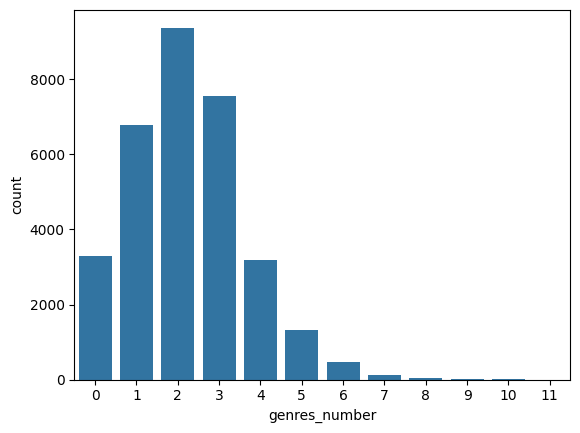

In [9]:
# Creating a new feature corresponding to 
# The counting of tags for each item
df_games['genres_number'] = df_games['genres'].map(lambda l: len(l) if l != 'Empty' else 0)

print('Maximum lenght of genres list:', df_games['genres_number'].max())
print('Average lenght of genres list:', round(df_games['genres_number'].mean(), 3))
print('Median:', df_games['genres_number'].median())
print('Std:', round(df_games['genres_number'].std()))

# Plotting distribution
sns.countplot(df_games, x='genres_number')

Unpacking to analyse unique values for tags and genres.

In [10]:
# List of every tag in the dataframe
tags = []

# Unpacking loop
for tag_list in df_games['tags']:
    if tag_list == 'Empty':
        continue
    for tag in tag_list:
        tags.append(tag)

# Converting to a pandas Series
tags = pd.Series(tags)

print('Total number of tags:', len(tags))
print('Unique ones:', len(pd.unique(tags)))

Total number of tags: 169209
Unique ones: 339


In [11]:
# List of every genre in the dataframe
genres = []

# Unpacking loop
for genres_list in df_games['genres']:
    if genres_list == 'Empty':
        continue
    for genre in genres_list:
        genres.append(genre)

# Converting to a pandas Series
genres = pd.Series(genres)

print('Total number of genres:', len(genres))
print('Unique ones:', len(pd.unique(genres)))

Total number of genres: 71552
Unique ones: 22


Text(0.5, 1.0, 'Genres dist')

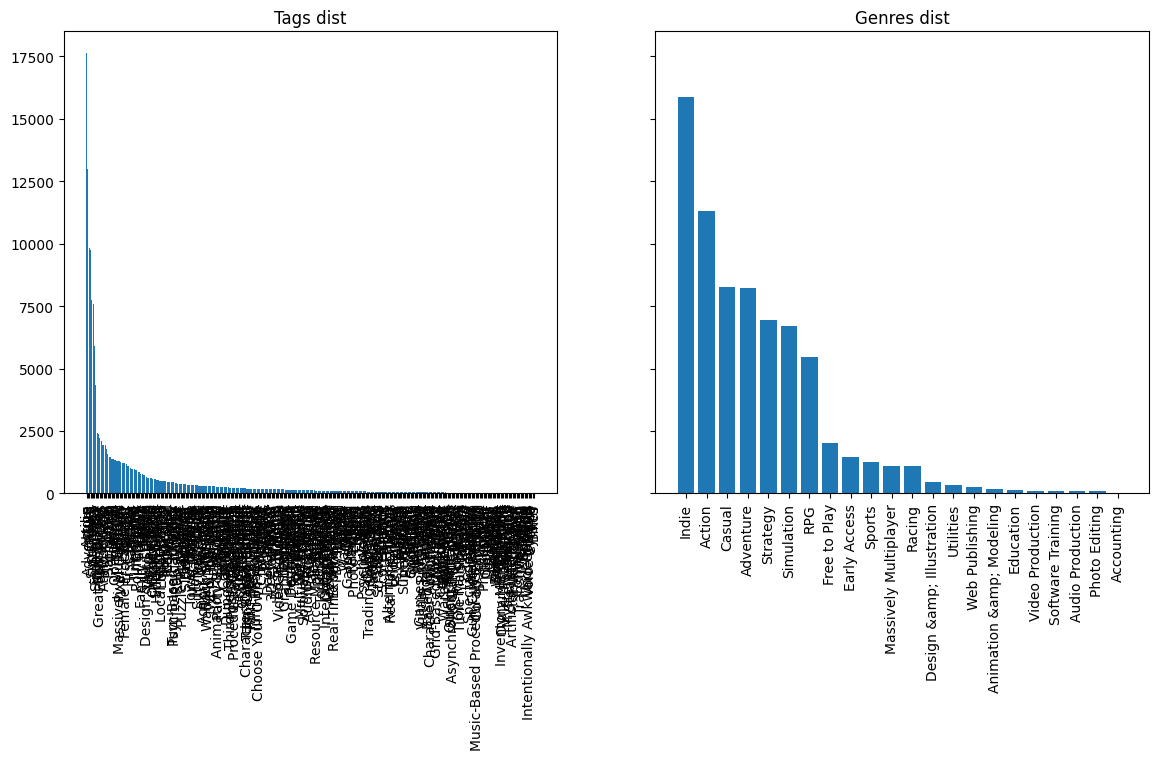

In [12]:
# Value counts for genres and tags
gen_c = genres.value_counts()
tag_c = tags.value_counts()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

axes[0].bar(tag_c.index, tag_c.values)
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title('Tags dist')

axes[1].bar(gen_c.index, gen_c.values)
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_title('Genres dist')

There are too many distinct tags. It is difficult to visualize. There is only **22 distinct genres** but **339 distinct tags**. 

Tags are **too specific** and **genres could be a better option to generalize**. Althoug tags provide more information, it would be a better choice to keep genres as they are general distinctions. Having dummies of every genre would be easiear and computationally less expensive than getting dummies for 344 tags.

The problem here is **having several items with empty lists of genres**. 

A similar analisys can be applied for 'specs' column.

Maximum number of specifications: 21
Average number of specifications: 4.567
Median: 4.0
Std: 3


<Axes: xlabel='specs_number', ylabel='count'>

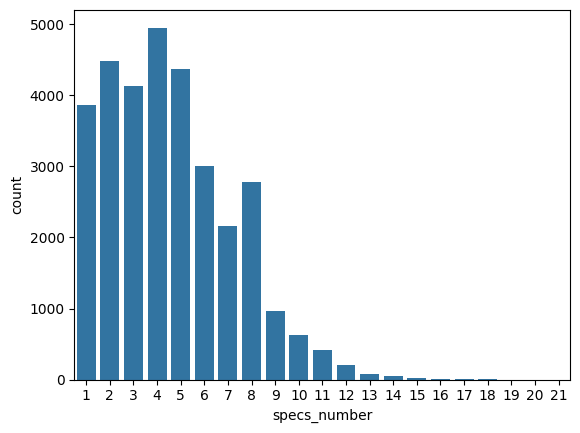

In [13]:
# Creating a new feature corresponding to 
# The counting of tags for each item
df_games['specs_number'] = df_games['specs'].map(len)

print('Maximum number of specifications:', df_games['specs_number'].max())
print('Average number of specifications:', round(df_games['specs_number'].mean(), 3))
print('Median:', df_games['specs_number'].median())
print('Std:', round(df_games['specs_number'].std()))

# Plotting distribution
sns.countplot(df_games, x='specs_number')

Unpacking

In [14]:
specs = []

for l in df_games['specs']:
    if l == 'Empty':
        continue
    for spec in l:
        specs.append(spec)

specs = pd.Series(specs)

print('Length:', len(specs))
print('Number of unique values:', len(pd.unique(specs)))

Length: 143418
Number of unique values: 40


Text(0, 0.5, 'Appearances')

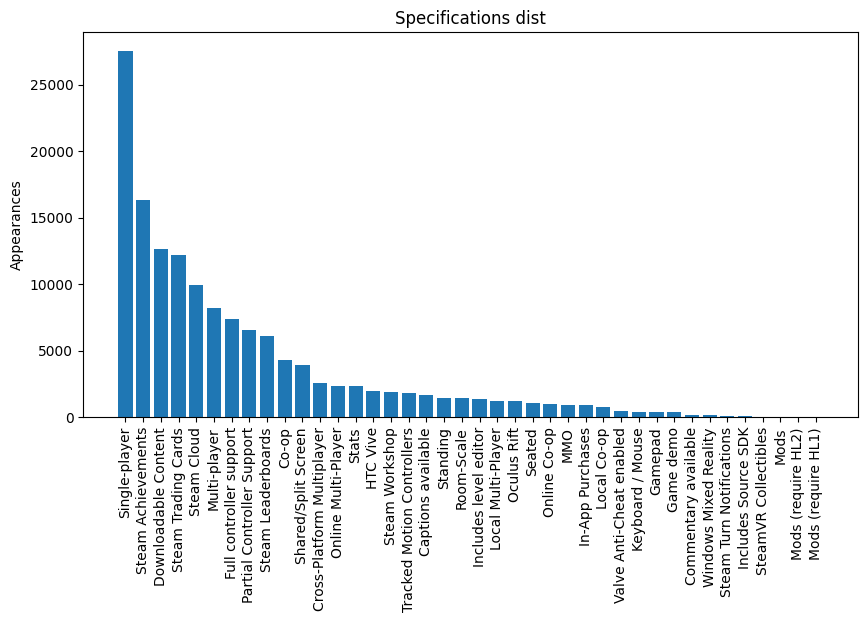

In [15]:
# Value counts for genres and tags
specs_c = specs.value_counts()


# Plotting
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(specs_c.index, specs_c.values)
ax.tick_params(axis='x', rotation=90)
ax.set_title('Specifications dist')
ax.set_ylabel('Appearances')

All three distributions for 'genres', 'tags' and 'specs' are right skewed. There is plenty of items with a lot of tags (more than 10) and more than a thousand with 20 tags. 'specs' distribution looks more normal and also has smaller deviation, although it presents positive skewness.

Something similar can be done for prices, let's see.

Before starting, some preprocessing is needed because there are some 'Free to play' labels.

In [16]:
pd.unique(df_games.price)

array([4.99, 'Free To Play', 'Free to Play', 0.99, 2.99, 3.99, 9.99,
       18.99, 29.99, 0, 'Free', 10.99, 1.5899999999999999, 14.99, 1.99,
       59.99, 8.99, 6.99, 7.99, 39.99, 19.99, 7.49, 12.99, 5.99, 2.49,
       15.99, 1.25, 24.99, 17.99, 61.99, 3.49, 11.99, 13.99, 'Free Demo',
       'Play for Free!', 34.99, 74.76, 1.49, 32.99, 99.99, 14.95, 69.99,
       16.99, 79.99, 49.99, 5.0, 44.99, 13.98, 29.96, 119.99, 109.99,
       149.99, 771.71, 'Install Now', 21.99, 89.99,
       'Play WARMACHINE: Tactics Demo', 0.98, 139.92, 4.29, 64.99,
       'Free Mod', 54.99, 74.99, 'Install Theme', 0.89, 'Third-party',
       0.5, 'Play Now', 299.99, 1.29, 3.0, 15.0, 5.49, 23.99, 49.0, 20.99,
       10.93, 1.3900000000000001, 'Free HITMAN™ Holiday Pack', 36.99,
       4.49, 2.0, 4.0, 9.0, 234.99, 1.9500000000000002, 1.5, 199.0, 189.0,
       6.66, 27.99, 10.49, 129.99, 179.0, 26.99, 399.99, 31.99, 399.0,
       20.0, 40.0, 3.33, 199.99, 22.99, 320.0, 38.85, 71.7, 59.95, 995.0,
       27.49, 3.

Looking at the unique values that column 'price' can take, it is now possible to extract floating values for analysis.

After inspecting values, 3 cases were identified:

1) There are floating numbers - Just taking the value.
2) Labels for free items ('Free to play' or 'Free To Play' or 'Install Now'). - Those can be replaced by zero.
2) Strings containing the price, for example 'Starting at $499.00'. - For these, ill use regular expressions to extract the value.

In [17]:
from functions import float_prices

df_games['price'] = df_games['price'].apply(float_prices)

df_games['price']

0        4.99
1        0.00
2        0.00
3        0.99
4        2.99
         ... 
32128    1.99
32129    4.99
32130    1.99
32131    4.99
32132    4.99
Name: price, Length: 32133, dtype: float64

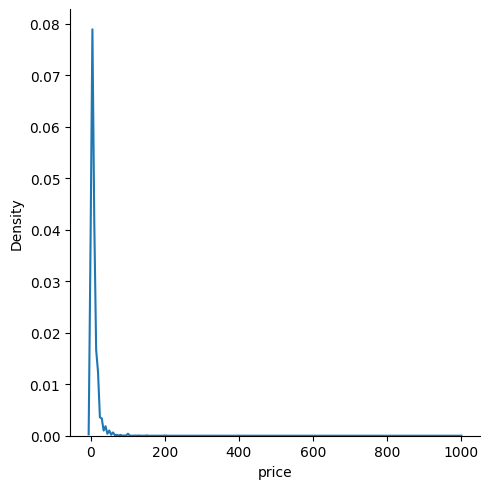

In [18]:
ax = sns.displot(
    data=df_games,
    x='price',
    kind='kde',
)

In [19]:
df_games[df_games['price'] > 100].shape

(61, 11)

Prices are condensed in a small area and there are very few values above 100.

In spite of havig that wide range or values, prices can be considered a good metric for similarity between games.

---

### **Defining Criteria to Measure Similarity: Feature Selection**

1) Genres and tags are the main attributes to determine whether 2 games are similar or not. Keeping in mind that tags are too specific, 'genres' column will be used for modeling.

2) There are some **hypothesis** for selecting the other features to build de recommendation system: 

- Groups of games released in a close period of time are more similar than those released in differente periods. A period could be months, years or decades, for example.

- Groups of games having similar prices are more similar than those with a large price difference.

- Specifications say a lot for the game content and game experience. They are a good measure for similarity.

According to the hypothesis, 'specs', 'release_year' and 'price' columns will also be selected to build the model:

- **Dummie** variables will be created for categorical features: Tags and Specifications.

- **Binning** technique will be used to handel numerical: Years and Prices.


---

### Preprocessing Basis

In [20]:
columns = ['item_id', 'app_name', 'genres', 'specs',
       'release_year', 'price']
df_games = df_games[columns]
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32133 entries, 0 to 32132
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       32133 non-null  int64  
 1   app_name      32133 non-null  object 
 2   genres        32133 non-null  object 
 3   specs         32133 non-null  object 
 4   release_year  32133 non-null  int64  
 5   price         32133 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 1.5+ MB


### Binning release years column

Years will be grouped:

- Released before 2000
- Released between 2000 and 2010
- Released after 2010

Once the column is grouped, pd.getdummies() can be applied.

In [21]:
def year_binning(y:int):
    if y < 2000:
        return 'Released before 2000'
    elif y >= 2000 and y < 2010:
        return 'Released in 2000-2010'
    else:
        return 'Released after 2010'
    
# Creating grouped column
df_games['release_period'] = df_games['release_year'].apply(year_binning)

# Getting dummies
df_games = pd.get_dummies(df_games, columns=['release_period'], prefix='', dtype=int)

# Dropping years column
df_games.drop(columns='release_year', inplace=True)

### Binning prices column

- Very low cost games are less than 5 USD.

- Cheap games between 5 and 30 USD.

- Typical for those between 30 and 60 USD.

- More than 60 USD can be considered expensive.

In [22]:
def price_binning(p:float):
    if p < 5:
        return 'Very low cost'
    elif p >= 5 and p < 30:
        return 'Cheap'
    elif p >= 30 and p < 60:
        return 'Typical price'
    else:
        return 'Expensive'
    
# Creating grouped column
df_games['cost'] = df_games['price'].apply(price_binning)

# Getting dummies
df_games = pd.get_dummies(df_games, columns=['cost'], prefix='', dtype=int)

# Dropping years column
df_games.drop(columns='price', inplace=True)

### One Hot Encoding for Genres and Specifications

...Will not be that simple 'cause these columns contain lists instead of single attributes.

In [23]:
# Series of genres to a set
unique_genres = list(genres.unique())

# Function to get the dummie rows
def genres_dummies(l):
    # Creating the dummie row
    row = np.zeros(len(unique_genres), dtype=int)
    # No genre returns row full of zeros
    if l == 'Empty':
        return row
    # Loop to check every single genre appearance.
    for pos, genre in enumerate(unique_genres):
        if genre in l:
            # update row position
            row[pos] = 1
    return row

array = df_games['genres'].apply(genres_dummies)

dummies_df = pd.DataFrame(data=array.tolist(), columns=unique_genres)
# Concatenating dataFrame
df_games = pd.concat([df_games, dummies_df], axis=1)
df_games.drop(columns='genres', inplace=True)

In [24]:
# Series of specs to a set
unique_specs = list(specs.unique())

# Function to get dummie rows
def specs_dummies(l):
    # Creating the dummie row
    row = np.zeros(len(unique_specs), dtype=int)
    # No specs returns a row full of zeros
    if l == 'Empty':
        return row
    # Loop to check every single genre appearance.
    for pos, spec in enumerate(unique_specs):
        if spec in l:
            # update row position
            row[pos] = 1
    return row

array = df_games['specs'].apply(specs_dummies)

dummies_df = pd.DataFrame(data=array.tolist(), columns=unique_specs)
# Concatenating dataFrame
df_games = pd.concat([df_games, dummies_df], axis=1)
df_games.drop(columns='specs', inplace=True)

In [25]:
df_games

,item_id,app_name,_Released after 2010,_Released before 2000,_Released in 2000-2010,_Cheap,_Expensive,_Medium price,Action,Casual,...,Includes level editor,Mods,Mods (require HL2),Game demo,Includes Source SDK,SteamVR Collectibles,Keyboard / Mouse,Gamepad,Windows Mixed Reality,Mods (require HL1)
0,761140,Lost Summoner Kitty,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,643980,Ironbound,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,670290,Real Pool 3D - Poolians,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,767400,弹炸人2222,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,773570,Log Challenge,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32128,773640,Colony On Mars,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
32129,733530,LOGistICAL: South Africa,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
32130,610660,Russian Roads,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32131,658870,EXIT 2 - Directions,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## **Recommender System** Using **Cosine Similarity**

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

In [44]:
x = df_games.iloc[0,2:].values.reshape(1,-1)
y = df_games.iloc[1,2:].values.reshape(1,-1)

In [45]:
cosine_similarity(X=x,Y=y)

array([[0.49029034]])

In [29]:
x.shape

(1, 55)

In [30]:
cosine_similarity(X=x, Y=y)

array([[0.13627703]])